In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

# change with your project path
%cd /content/drive/MyDrive/Photo_Math_Project
sys.path.append('./utils/')

/content/drive/MyDrive/Photo_Math_Project


In [ ]:
import torch
import torch.nn as nn
import classificator as cl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import os
from torch.optim.lr_scheduler import StepLR

### load the dataset to get the grammar size

In [ ]:
train_img = np.load("./symbol_datasets/train_symb_imgs.npy")
test_img = np.load("./symbol_datasets/test_symb_imgs.npy")
train_labels = np.load("./symbol_datasets/train_symb_labels.npy")
test_labels = np.load("./symbol_datasets/test_symb_labels.npy")

In [ ]:
train_img.shape

(91180, 45, 45)

In [ ]:
grammar = list(set(test_labels))
grammar.sort()
class_encoder = {}
class_decoder = {} #unimportant
for i, symb in enumerate(grammar):
  class_encoder[symb] = i
  class_decoder[i] = symb

### change the last layer in the model

In [ ]:
pretrained_model = cl.Classificator(len(grammar), 1)
pretrained_model.load_state_dict(torch.load('./Models/symbol_classificaton_model.pth'))

<All keys matched successfully>

## Define dataloaders

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self, imgs, labels, class_encoder, transform = None):
    self.imgs = imgs
    self.labels = labels
    self.transform = transform
    self.class_encoder = class_encoder

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img = self.imgs[idx]
    label = self.labels[idx]

    if self.transform != None:
      img = self.transform(img)

    return img, self.class_encoder[label]


In [ ]:
from torchvision import transforms
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x*2)-1)
])

augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1), fill =1), # zoom
    transforms.RandomAffine(degrees=(-5, 5), fill = 1), #rotation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), fill = 1), # translation
    transforms.Lambda(lambda x: (x*2)-1)
])

train_dataset = CustomDataset(train_img, train_labels, class_encoder, augmentation)
val_dataset = CustomDataset(test_img, test_labels, class_encoder, basic_transform)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, ')')

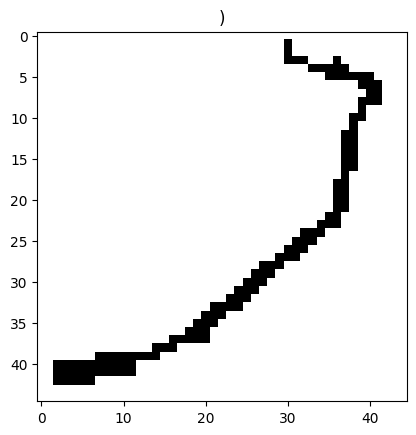

In [ ]:
a, b = next(iter(train_loader))
plt.imshow(a[3].squeeze(), cmap='gray')
plt.title(class_decoder[b[3].item()])

## Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
pretrained_model.to(device)

Classificator(
  (skip1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (skip2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (skip3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
num_epochs = 20
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=9.82e-06, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)

In [ ]:
# early stopping params
patience = 3
best_val_loss = 0.2571779632116309
early_stop_count = 0

In [ ]:
train_loss_hist = []
test_loss_hist = []

save_dir = './Models/symbol_classificaton_model.pth'
model_name = 'symbol_classificaton_model'

for epoch in range(num_epochs):

    # iterate for train data
    train_loss = 0.0
    pbar = tqdm(train_loader)
    pretrained_model.train()
    for batch in pbar:
        images, labels = batch
        outputs = pretrained_model(images.to(device))

        loss_value = loss_func(outputs, labels.to(device))

        train_loss += loss_value.item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        pbar.set_description(f'epoch {epoch+1}, train loss {loss_value.item():.4f}')

    train_loss /= len(train_loader)
    scheduler.step()

    # iterate for validation data
    val_loss = 0.0

    pbar = tqdm(val_loader)
    pretrained_model.eval()
    with torch.no_grad():
      for batch in pbar:
          images, labels = batch
          outputs = pretrained_model(images.to(device))

          loss_value = loss_func(outputs, labels.to(device))

          val_loss += loss_value.item()

          pbar.set_description(f'epoch {epoch+1}, val loss {loss_value.item():.4f}')

    val_loss /= len(val_loader)

    # check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Early stopping after {epoch + 1} epochs")
            break

    # add loss to history
    train_loss_hist.append(train_loss)
    test_loss_hist.append(val_loss)

    print(f"Epoch {epoch+1} | train_cost: {train_loss_hist[-1]} | val_cost: {test_loss_hist[-1]}")

    #save the model if it has the best val_loss
    if best_val_loss == val_loss:
      os.makedirs(save_dir, exist_ok=True)
      torch.save(pretrained_model.state_dict(), save_dir + f"{model_name}.pth")
      print('saved model at ' + save_dir + f"{model_name}.pth")

# save train values
with open('./Loss_data/symbol_loss_data.pkl', 'wb') as file:
  pickle.dump((train_loss_hist,test_loss_hist), file)

### plot training curves

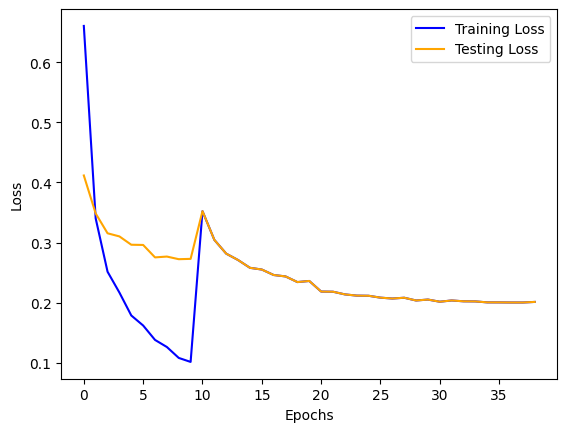

In [ ]:
with open('./Loss_data/symbol_loss_data.pkl', 'rb') as file:
    train_loss_hist, test_loss_hist = pickle.load(file)

plt.plot(train_loss_hist, label='Training Loss', color='blue')

plt.plot(test_loss_hist, label='Testing Loss', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### model accuracy

In [ ]:
pretrained_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_model(images)
        predicted = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Model accuracy: {accuracy}%')

Model accuracy: 92.90226355500965%


### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
true_labels = []
predicted_labels = []

for images, labels in val_dataset:
    predictions = pretrained_model(images.to(device).unsqueeze(0))
    predicted_labels.extend(np.argmax(predictions.detach().cpu().numpy(), axis=1))
    true_labels.append(labels)

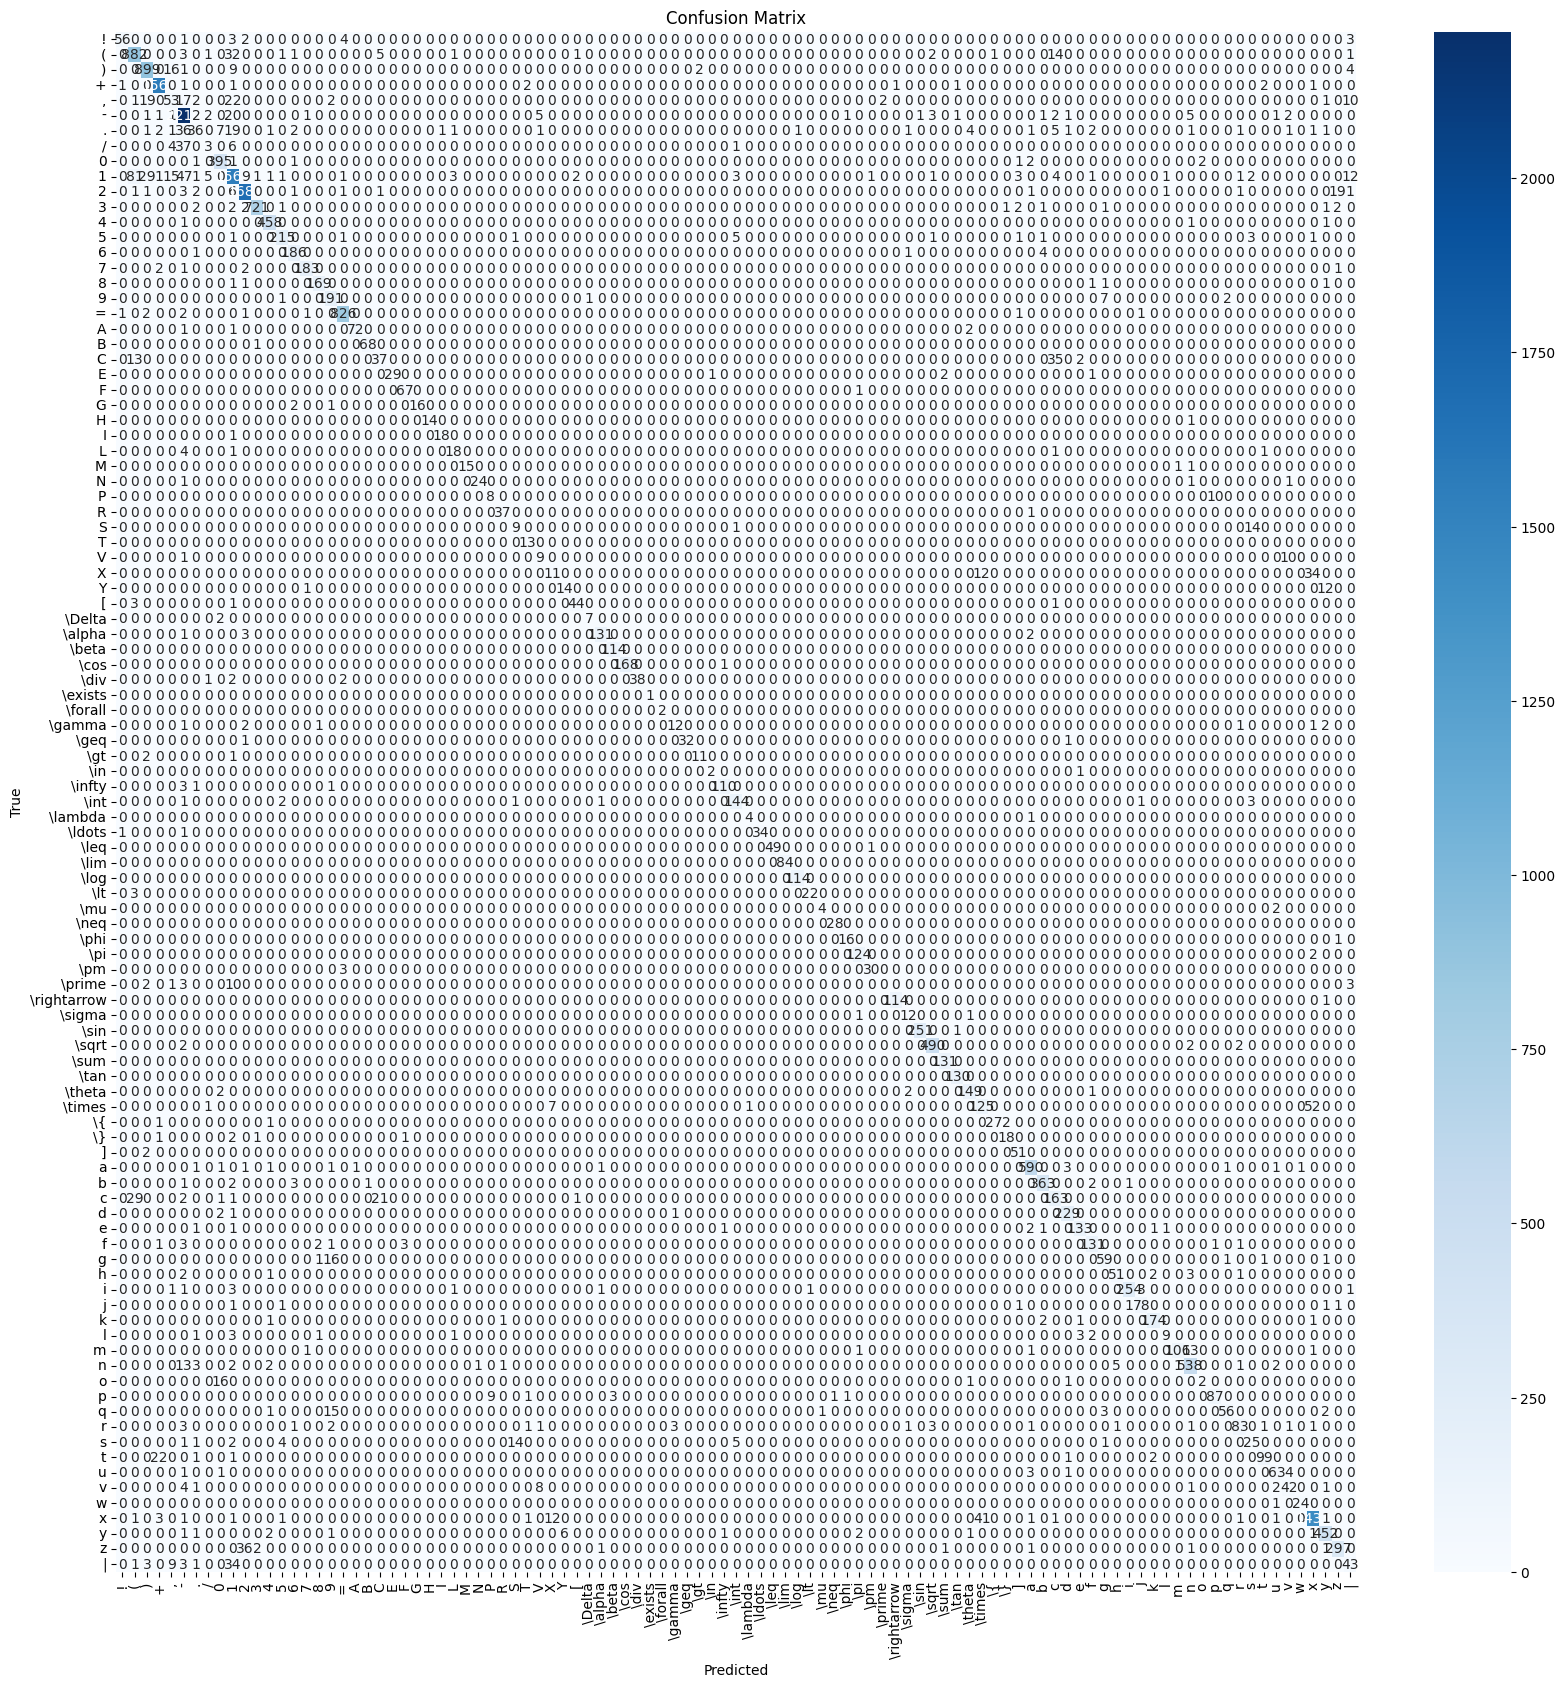

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=grammar, yticklabels=grammar)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()